The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# *Perceptrons* Multicamada
:label:`sec_mlp`

Em :numref:`chap_linear`,, apresentamos
regressão *softmax* (:numref:`sec_softmax`),
implementando o algoritmo do zero
(:numref:`sec_softmax_scratch`) e usando APIs de alto nível
(:numref:`sec_softmax_concise`),
e classificadores de treinamento para reconhecer
10 categorias de roupas a partir de imagens de baixa resolução.
Ao longo do caminho, aprendemos como organizar dados,
coagir nossos resultados em uma distribuição de probabilidade válida,
aplicar uma função de perda apropriada,
e minimizá-la em relação aos parâmetros do nosso modelo.
Agora que dominamos essa mecânica
no contexto de modelos lineares simples,
podemos lançar nossa exploração de redes neurais profundas,
a classe comparativamente rica de modelos
com o qual este livro se preocupa principalmente.

## Camadas Ocultas

Descrevemos a transformação afim em
:numref:`subsec_linear_model`,
que é uma transformação linear adicionada por um *bias.
Para começar, relembre a arquitetura do modelo
correspondendo ao nosso exemplo de regressão *softmax*,
ilustrado em :numref:`fig_softmaxreg`.
Este modelo mapeou nossas entradas diretamente para nossas saídas
por meio de uma única transformação afim,
seguido por uma operação *softmax*.
Se nossos *labels* realmente estivessem relacionados
aos nossos dados de entrada por uma transformação afim,
então esta abordagem seria suficiente.
Mas a linearidade nas transformações afins é uma suposição *forte*.

### Modelos Lineares Podem Dar Errado


Por exemplo, linearidade implica a *mais fraca*
suposição de *monotonicidade*:
que qualquer aumento em nosso recurso deve
sempre causar um aumento na saída do nosso modelo
(se o peso correspondente for positivo),
ou sempre causa uma diminuição na saída do nosso modelo
(se o peso correspondente for negativo).
Às vezes, isso faz sentido.
Por exemplo, se estivéssemos tentando prever
se um indivíduo vai pagar um empréstimo,
podemos razoavelmente imaginar que mantendo tudo o mais igual,
um candidato com uma renda maior
sempre estaria mais propenso a retribuir
do que um com uma renda mais baixa.
Embora monotônico, esse relacionamento provavelmente
não está linearmente associado à probabilidade de
reembolso. Um aumento na receita de 0 a 50 mil
provavelmente corresponde a um aumento maior
em probabilidade de reembolso
do que um aumento de 1 milhão para 1,05 milhão.
Uma maneira de lidar com isso pode ser pré-processar
nossos dados de forma que a linearidade se torne mais plausível,
digamos, usando o logaritmo da receita como nosso recurso.


Observe que podemos facilmente encontrar exemplos
que violam a monotonicidade.
Digamos, por exemplo, que queremos prever a probabilidade
de morte com base na temperatura corporal.
Para indivíduos com temperatura corporal
acima de 37 ° C (98,6 ° F),
temperaturas mais altas indicam maior risco.
No entanto, para indivíduos com temperatura corporal
abaixo de 37 ° C, temperaturas mais altas indicam risco menor!
Também neste caso, podemos resolver o problema
com algum pré-processamento inteligente.
Ou seja, podemos usar a distância de 37 ° C como nossa *feature*.


Mas que tal classificar imagens de cães e gatos?
Aumentar a intensidade
do pixel no local (13, 17) deveria
sempre aumentar (ou sempre diminuir)
a probabilidade de que a imagem retrate um cachorro?
A confiança em um modelo linear corresponde à implícita
suposição de que o único requisito
para diferenciar gatos vs. cães é avaliar
o brilho de pixels individuais.
Esta abordagem está fadada ao fracasso em um mundo
onde inverter uma imagem preserva a categoria.


E ainda, apesar do aparente absurdo da linearidade aqui,
em comparação com nossos exemplos anteriores,
é menos óbvio que poderíamos resolver o problema
com uma correção de pré-processamento simples.
Isso ocorre porque o significado de qualquer pixel
depende de maneiras complexas de seu contexto
(os valores dos pixels circundantes).
Embora possa existir uma representação de nossos dados
isso levaria em consideração
as interações relevantes entre nossas características,
no topo das quais um modelo linear seria adequado, nós
simplesmente não sabemos como calculá-lo à mão.
Com redes neurais profundas, usamos dados observacionais
para aprender conjuntamente uma representação por meio de camadas ocultas
e um preditor linear que atua sobre essa representação.


### Incorporando Camadas Ocultas


Podemos superar essas limitações dos modelos lineares
e lidar com uma classe mais geral de funções
incorporando uma ou mais camadas ocultas.
A maneira mais fácil de fazer isso é empilhar
muitas camadas totalmente conectadas umas sobre as outras.
Cada camada alimenta a camada acima dela,
até gerarmos resultados.
Podemos pensar nas primeiras $L-1$ camadas
como nossa representação e a camada final
como nosso preditor linear.
Esta arquitetura é comumente chamada
um *perceptron multicamadas*,
frequentemente abreviado como *MLP*.
Abaixo, representamos um MLP em diagrama (:numref:`fig_mlp`).

![Um MLP com uma camada oculta de 5 unidades ocultas. ](http://d2l.ai/_images/mlp.svg) :label:`fig_mlp`

Este MLP tem 4 entradas, 3 saídas,
e sua camada oculta contém 5 unidades ocultas.
Uma vez que a camada de entrada não envolve nenhum cálculo,
produzindo saídas com esta rede
requer a implementação dos cálculos
para as camadas ocultas e de saída;
assim, o número de camadas neste MLP é 2.
Observe que essas camadas estão totalmente conectadas.
Cada entrada influencia cada neurônio na camada oculta,
e cada um deles, por sua vez, influencia
cada neurônio na camada de saída.
No entanto, conforme sugerido por :numref:`subsec_parameterization-cost-fc-layers`,
o custo de parametrização de MLPs
com camadas totalmente conectadas
pode ser proibitivamente alto,
o que pode motivar
compensação entre o salvamento do parâmetro e a eficácia do modelo, mesmo sem alterar o tamanho de entrada ou saída :cite:`Zhang.Tay.Zhang.ea.2021`.


### De Linear Para não Linear


Como antes, pela matriz $\mathbf{X} \in \mathbb{R}^{n \times d}$,
denotamos um *minibatch* de $n$ exemplos em que cada exemplo tem $d$ entradas (*features*).
Para um MLP de uma camada oculta, cuja camada oculta tem $h$ unidades ocultas,
denotamos por $\mathbf{H} \in \mathbb{R}^{n \times h}$
as saídas da camada oculta, que são
*representações ocultas*.
Em matemática ou código, $\mathbf{H}$ também é conhecido como uma *variável de camada oculta* ou uma *variável oculta*.
Uma vez que as camadas ocultas e de saída estão totalmente conectadas,
temos pesos de camada oculta $\mathbf{W}^{(1)} \in \mathbb{R}^{d \times h}$ e *bias* $\mathbf{b}^{(1)} \in \mathbb{R}^{1 \times h}$
e pesos da camada de saída $\mathbf{W}^{(2)} \in \mathbb{R}^{h \times q}$ e *bias* $\mathbf{b}^{(2)} \in \mathbb{R}^{1 \times q}$.
Formalmente, calculamos as saídas $\mathbf{O} \in \mathbb{R}^{n \times q}$
do MLP de uma camada oculta da seguinte maneira:

$$
\begin{aligned}
    \mathbf{H} & = \mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}, \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.
\end{aligned}
$$




Observe que depois de adicionar a camada oculta,
nosso modelo agora exige que rastreemos e atualizemos
conjuntos adicionais de parâmetros.
Então, o que ganhamos em troca?
Você pode se surpreender ao descobrir
que --- no modelo definido acima --- *nós
não ganhamos nada pelos nossos problemas*!
O motivo é claro.
As unidades ocultas acima são fornecidas por
uma função afim das entradas,
e as saídas (pré-*softmax*) são apenas
uma função afim das unidades ocultas.
Uma função afim de uma função afim
é em si uma função afim.
Além disso, nosso modelo linear já era
capaz de representar qualquer função afim.


Podemos ver a equivalência formalmente
provando que para quaisquer valores dos pesos,
podemos apenas recolher a camada oculta,
produzindo um modelo de camada única equivalente com parâmetros
$\mathbf{W} = \mathbf{W}^{(1)}\mathbf{W}^{(2)}$ and $\mathbf{b} = \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)}$:


$$
\mathbf{O} = (\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})\mathbf{W}^{(2)} + \mathbf{b}^{(2)} = \mathbf{X} \mathbf{W}^{(1)}\mathbf{W}^{(2)} + \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)} = \mathbf{X} \mathbf{W} + \mathbf{b}.
$$


Para perceber o potencial das arquiteturas multicamadas,
precisamos de mais um ingrediente chave: a
*função de ativação* não linear $\sigma$
a ser aplicada a cada unidade oculta
seguindo a transformação afim.
As saídas das funções de ativação
(por exemplo, $\sigma(\cdot)$)
são chamadas de *ativações*.
Em geral, com as funções de ativação implementadas,
não é mais possível reduzir nosso MLP em um modelo linear:

$$
\begin{aligned}
    \mathbf{H} & = \sigma(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}), \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.\\
\end{aligned}
$$


Uma vez que cada linha em $\mathbf{X}$ corresponde a um exemplo no *minibatch*,
com algum abuso de notação, definimos a não linearidade
$\sigma$ para aplicar às suas entradas de uma forma em linha,
ou seja, um exemplo de cada vez.
Observe que usamos a notação para *softmax*
da mesma forma para denotar uma operação nas linhas em :numref:`subsec_softmax_vectorization`.
Frequentemente, como nesta seção, as funções de ativação
que aplicamos a camadas ocultas não são apenas nas linhas,
mas elemento a elemento.
Isso significa que depois de calcular a parte linear da camada,
podemos calcular cada ativação
sem olhar para os valores assumidos pelas outras unidades ocultas.
Isso é verdadeiro para a maioria das funções de ativação.


Para construir MLPs mais gerais, podemos continuar empilhando
tais camadas escondidas,
por exemplo, $\mathbf{H}^{(1)} = \sigma_1(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})$
e $\mathbf{H}^{(2)} = \sigma_2(\mathbf{H}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)})$,
uma sobre a outra, rendendo modelos cada vez mais expressivos.

### Aproximadores Universais


MLPs podem capturar interações complexas
entre nossas entradas por meio de seus neurônios ocultos,
que dependem dos valores de cada uma das entradas.
Podemos projetar nós ocultos facilmente
para realizar cálculos arbitrários,
por exemplo, operações lógicas básicas em um par de entradas.
Além disso, para certas escolhas da função de ativação,
é amplamente conhecido que os MLPs são aproximadores universais.
Mesmo com uma rede de camada única oculta,
dados nós suficientes (possivelmente absurdamente muitos deles),
e o conjunto certo de pesos,
podemos modelar qualquer função,
embora realmente aprender essa função seja a parte difícil.
Você pode pensar em sua rede neural
como sendo um pouco como a linguagem de programação C.
A linguagem, como qualquer outra linguagem moderna,
é capaz de expressar qualquer programa computável.
Mas, na verdade, criar um programa
que atenda às suas especificações é a parte difícil.

Além disso, só porque uma rede de camada única oculta
*pode* aprender qualquer função
não significa que você deve tentar
resolver todos os seus problemas
com redes de camada única oculta.
Na verdade, podemos aproximar muitas funções
de forma muito mais compacta, usando redes mais profundas (em comparação com redes mais amplas).
Trataremos de argumentos mais rigorosos nos capítulos subsequentes.


## Funções de Ativação
:label:`subsec_activation-functions`

As funções de ativação decidem se um neurônio deve ser ativado ou não por
calcular a soma ponderada e adicionar ainda o *bias* com ela.
Eles são operadores diferenciáveis para transformar sinais de entrada em saídas,
enquanto a maioria deles adiciona não linearidade.
Como as funções de ativação são fundamentais para o *deep learning*,
(**vamos examinar brevemente algumas funções de ativação comuns**).


In [1]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l

### Função ReLU

A escolha mais popular,
devido à simplicidade de implementação e
seu bom desempenho em uma variedade de tarefas preditivas,
é a *unidade linear retificada* (*ReLU*).
[**ReLU fornece uma transformação não linear muito simples**].
Dado um elemento $x$, a função é definida
como o máximo desse elemento e $0$:

$$\operatorname{ReLU}(x) = \max(x, 0).$$

Informalmente, a função ReLU retém apenas
elementos positivos e descarta todos os elementos negativos
definindo as ativações correspondentes para 0.
Para obter alguma intuição, podemos representar graficamente a função.
Como você pode ver, a função de ativação é linear por partes.


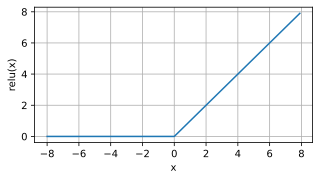

In [2]:
x = tf.Variable(tf.range(-8.0, 8.0, 0.1), dtype=tf.float32)
y = tf.nn.relu(x)
d2l.plot(x.numpy(), y.numpy(), 'x', 'relu(x)', figsize=(5, 2.5))

Quando a entrada é negativa,
a derivada da função ReLU é 0,
e quando a entrada é positiva,
a derivada da função ReLU é 1.
Observe que a função ReLU não é diferenciável
quando a entrada assume um valor precisamente igual a 0.
Nesses casos, o padrão é o lado esquerdo da
derivada, e dizemos que a derivada é 0 quando a entrada é 0.
Podemos escapar impunes porque
a entrada pode nunca ser realmente zero.
Há um velho ditado que diz que se as condições de contorno sutis são importantes,
provavelmente estamos fazendo matemática (*real*), não engenharia.
Essa sabedoria convencional pode se aplicar aqui.
Plotamos a derivada da função ReLU abaixo.


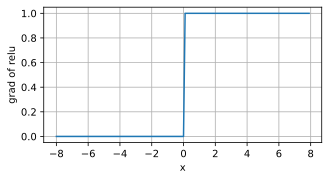

In [3]:
with tf.GradientTape() as t:
    y = tf.nn.relu(x)
d2l.plot(x.numpy(), t.gradient(y, x).numpy(), 'x', 'grad of relu',
         figsize=(5, 2.5))

A razão para usar ReLU é que
suas derivadas são particularmente bem comportadas:
ou elas desaparecem ou simplesmente deixam * argumento passar.
Isso torna a otimização melhor comportada
e mitiga o problema bem documentado
de gradientes de desaparecimento que atormentaram
versões anteriores de redes neurais (mais sobre isso mais tarde).

Observe que existem muitas variantes da função ReLU,
incluindo a função *ReLU parametrizada* (*pReLU*) :cite:`He.Zhang.Ren.ea.2015`.
Esta variação adiciona um termo linear ao ReLU,
então algumas informações ainda são transmitidas,
mesmo quando o argumento é negativo:

$$\operatorname{pReLU}(x) = \max(0, x) + \alpha \min(0, x).$$

### Função Sigmoid

[**A *função sigmoid* transforma suas entradas**],
para as quais os valores estão no domínio $\mathbb{R}$,
(**para saídas que estão no intervalo (0, 1).**)
Por esse motivo, o sigmoid é
frequentemente chamada de *função de esmagamento*:
ele esmaga qualquer entrada no intervalo (-inf, inf)
para algum valor no intervalo (0, 1):

$$\operatorname{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.$$


Nas primeiras redes neurais, os cientistas
estavam interessados ​​em modelar neurônios biológicos
que *disparam* ou *não disparam*.
Assim, os pioneiros neste campo,
voltando para McCulloch e Pitts,
os inventores do neurônio artificial,
focaram em unidades de limiar.
Uma ativação de limite assume valor 0
quando sua entrada está abaixo de algum limite
e valor 1 quando a entrada excede o limite.


Quando a atenção mudou para o aprendizado baseado em gradiente,
a função sigmoid foi uma escolha natural
porque é uma boa, diferenciável
aproximação a uma unidade de limiar.
Sigmoids ainda são amplamente usados ​​como
funções de ativação nas unidades de saída,
quando queremos interpretar as saídas como probabilidades
para problemas de classificação binária
(você pode pensar na sigmoid como um caso especial do *softmax*).
No entanto, a sigmoid foi quase toda substituído
pelo ReLU, mais simples e facilmente treinável
para mais uso em camadas ocultas.
Em capítulos posteriores sobre redes neurais recorrentes,
iremos descrever arquiteturas que alavancam unidades sigmoid
para controlar o fluxo de informações ao longo do tempo.

Abaixo, traçamos a função sigmoid.
Observe que quando a entrada está próxima de 0,
a função sigmoid se aproxima
uma transformação linear.


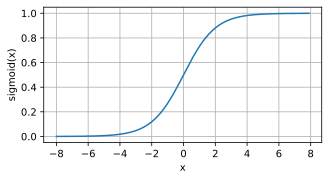

In [4]:
y = tf.nn.sigmoid(x)
d2l.plot(x.numpy(), y.numpy(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

A derivada da função sigmoid  é dada pela seguinte equação:

$$\frac{d}{dx} \operatorname{sigmoid}(x) = \frac{\exp(-x)}{(1 + \exp(-x))^2} = \operatorname{sigmoid}(x)\left(1-\operatorname{sigmoid}(x)\right).$$


A derivada da função sigmoid é plotada abaixo.
Observe que quando a entrada é 0,
a derivada da função sigmoid
atinge um máximo de 0,25.
À medida que a entrada diverge de 0 em qualquer direção,
a derivada se aproxima de 0.


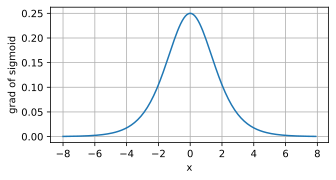

In [5]:
with tf.GradientTape() as t:
    y = tf.nn.sigmoid(x)
d2l.plot(x.numpy(), t.gradient(y, x).numpy(), 'x', 'grad of sigmoid',
         figsize=(5, 2.5))

### Função Tanh

Como a função sigmoid, [**a tanh (tangente hiperbólica)
função também comprime suas entradas**],
transformando-as em elementos no intervalo (**entre -1 e 1**):

$$\operatorname{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.$$

Traçamos a função tanh abaixo.
Observe que, à medida que a entrada se aproxima de 0, a função tanh se aproxima de uma transformação linear. Embora a forma da função seja semelhante à da função sigmoid, a função tanh exibe uma simetria de ponto sobre a origem do sistema de coordenadas.


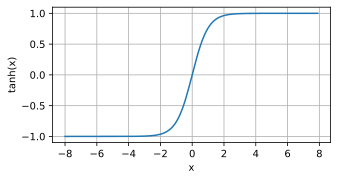

In [6]:
y = tf.nn.tanh(x)
d2l.plot(x.numpy(), y.numpy(), 'x', 'tanh(x)', figsize=(5, 2.5))

A derivada da função tanh é:

$$\frac{d}{dx} \operatorname{tanh}(x) = 1 - \operatorname{tanh}^2(x).$$

A derivada da função tanh é plotada abaixo.
Conforme a entrada se aproxima de 0,
a derivada da função tanh se aproxima de um máximo de 1.
E como vimos com a função sigmoid,
conforme a entrada se afasta de 0 em qualquer direção,
a derivada da função tanh se aproxima de 0.


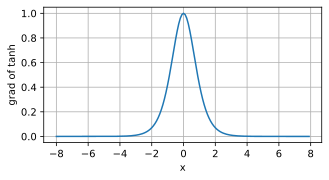

In [7]:
with tf.GradientTape() as t:
    y = tf.nn.tanh(x)
d2l.plot(x.numpy(), t.gradient(y, x).numpy(), 'x', 'grad of tanh',
         figsize=(5, 2.5))

Em resumo, agora sabemos como incorporar não linearidades
para construir arquiteturas de rede neural multicamadas expressivas.
Como uma nota lateral, o seu conhecimento já
coloca você no comando de um kit de ferramentas semelhante
para um praticante por volta de 1990.
De certa forma, você tem uma vantagem
sobre qualquer pessoa que trabalhou na década de 1990,
porque você pode alavancar
*frameworks* de *deep learning* de código aberto
para construir modelos rapidamente, usando apenas algumas linhas de código.
Anteriormente, o treinamento dessas redes
pesquisadores obrigados a codificar
milhares de linhas de C e Fortran.

## Resumo

* O MLP adiciona uma ou várias camadas ocultas totalmente conectadas entre as camadas de saída e de entrada e transforma a saída da camada oculta por meio de uma função de ativação.
* As funções de ativação comumente usadas incluem a função ReLU, a função sigmoid e a função tanh.


## Exercícios

1. Calcule a derivada da função de ativação pReLU.
1. Mostre que um MLP usando apenas ReLU (ou pReLU) constrói uma função linear contínua por partes.
1. Mostre que $\operatorname{tanh}(x) + 1 = 2 \operatorname{sigmoid}(2x)$.
1. Suponha que temos uma não linearidade que se aplica a um *minibatch* por vez. Que tipo de problemas você espera que isso cause?


[Discussions](https://discuss.d2l.ai/t/226)


<!--stackedit_data:
eyJoaXN0b3J5IjpbMTE3NTA1ODMwLC0xNDQxNzc4NDA0LDEzND
kyMDI2NDEsMjA0MTA5NjAyNSwxNjM3ODEzNTgzLC01MTM2MzYz
NzksLTE0ODQzOTk4NzgsLTIwNjAxMDE1MzQsODQ5OTk1NzEwLD
cxMzExNTk0NV19
-->
